## Setting Device

In [1]:
import torch

# Change X to the GPU number you want to use,
# e.g. USE_GPU = 4
USE_GPU = 6

print ('Available devices: ', torch.cuda.device_count())
device = torch.device("cuda:"+str(USE_GPU) if torch.cuda.is_available() else "cpu")
print("device: ", device)

Available devices:  8
device:  cuda:6


# GCN Model

In [2]:
import numpy as np
import torch
from torch_geometric.data import Data, Batch
import torch_geometric.nn as gnn
import torch.nn.functional as F
from torch.nn import ModuleList

class MoveNet(torch.nn.Module): # To try things out
    def __init__(self):
        super(MoveNet, self).__init__()
        
        self.sage8_mean = gnn.SAGEConv(2, 8, aggr='mean', root_weight=True)
        self.sage16_mean = gnn.SAGEConv(8, 16, aggr='mean', root_weight=True)
        self.sage32_mean = gnn.SAGEConv(16, 32, aggr='mean', root_weight=True)
        self.sage64_mean = gnn.SAGEConv(32, 64, aggr='mean', root_weight=True)
        
        self.bn8_mean = gnn.BatchNorm(8)
        self.bn16_mean = gnn.BatchNorm(16)
        self.bn32_mean = gnn.BatchNorm(32)
        self.bn64_mean = gnn.BatchNorm(64)

        self.fc = gnn.Linear(64, 3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        m = self.sage8_mean(x, edge_index)
        m = self.bn8_mean(m)
        m = F.relu(m)
        
        m = self.sage16_mean(m, edge_index)
        m = self.bn16_mean(m)
        m = F.relu(m)
        
        m = self.sage32_mean(m, edge_index)
        m = self.bn32_mean(m)
        m = F.relu(m)
        
        m = self.sage64_mean(m, edge_index)
        m = self.bn64_mean(m)
        m = F.relu(m)
        
        m = self.fc(m)
        
        return F.log_softmax(m, dim=1)
    
class BuildingSimplModel(torch.nn.Module): # From Zhou's paper with some addition
    def __init__(self):
        super(BuildingSimplModel, self).__init__()
        self.rm_4 = gnn.SAGEConv(2, 4, aggr='mean')
        self.rm_norm4 = gnn.BatchNorm(4)
        
        self.rm_8 = gnn.SAGEConv(4, 8, aggr='mean')
        self.rm_norm8 = gnn.BatchNorm(8)
        
        self.rm_64 = gnn.SAGEConv(8, 64, aggr='mean')
        self.rm_norm64 = gnn.BatchNorm(64)
        
        self.rm_32 = gnn.SAGEConv(64, 32, aggr='mean')
        self.rm_norm32 = gnn.BatchNorm(32)
        
        self.rm_16 = gnn.SAGEConv(32, 16, aggr='mean')
        self.rm_norm16 = gnn.BatchNorm(16)
        
        self.rm_3 = gnn.SAGEConv(16, 3, aggr='mean')
        
        # ------------
        
        self.mv_4 = gnn.SAGEConv(2, 4, aggr='mean')
        self.mv_norm4 = gnn.BatchNorm(4)
        
        self.mv_8 = gnn.SAGEConv(4, 8, aggr='mean')
        self.mv_norm8 = gnn.BatchNorm(8)
        
        self.mv_rm = gnn.SAGEConv(8 + 3, 64, aggr='mean')
        self.mv_rm_norm = gnn.BatchNorm(64)
        
        self.x_mv_32 = gnn.SAGEConv(64, 32, aggr='mean')
        self.x_mv_norm32 = gnn.BatchNorm(32)
        self.x_mv_16 = gnn.SAGEConv(32, 16, aggr='mean')
        self.x_mv_norm16 = gnn.BatchNorm(16)
        self.x_mv_fc = gnn.Linear(16, 1)
        
        self.y_mv_32 = gnn.SAGEConv(64, 32, aggr='mean')
        self.y_mv_norm32 = gnn.BatchNorm(32)
        self.y_mv_16 = gnn.SAGEConv(32, 16, aggr='mean')
        self.y_mv_norm16 = gnn.BatchNorm(16)
        self.y_mv_fc = gnn.Linear(16, 1)
        
        self.loss_weights = torch.nn.Parameter(data=torch.ones(3).uniform_(0.2, 1), requires_grad=True)
        
        # ------------
        
        self.op_class = ModuleList([self.rm_4, self.rm_norm4])
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        op = F.relu( self.rm_norm4( self.rm_4(x, edge_index)))
        
        op = F.relu( self.rm_norm8( self.rm_8(op, edge_index)))
        
        op = F.relu( self.rm_norm64( self.rm_64(op, edge_index)))
        
        op = F.relu( self.rm_norm32( self.rm_32(op, edge_index)))

        op = F.relu( self.rm_norm16( self.rm_16(op, edge_index)))

        op_scores = self.rm_3(op, edge_index)
        
        op_probs = F.log_softmax(op_scores, dim=1)
        
        op_labels = op_probs.argmax(1)
        
        move_only = torch.where(op_labels == 1, 1, 0)
        
        # ------------
        
        mv = F.relu( self.mv_norm4( self.mv_4(x, edge_index)))
        
        mv = F.relu( self.mv_norm8( self.mv_8(mv, edge_index)))
        
        mv = F.relu( self.mv_rm_norm( self.mv_rm( torch.cat((mv, op_scores), 1), edge_index)))
        
        # ------------
        
        x_mv = F.relu( self.x_mv_norm32( self.x_mv_32(mv, edge_index)))
        
        x_mv = F.relu( self.x_mv_norm16( self.x_mv_16(x_mv, edge_index)))
        
        x_mv = self.x_mv_fc(x_mv)
        
        x_mv = torch.mul(x_mv.squeeze(), move_only)
        
        # ------------
        
        y_mv = F.relu( self.y_mv_norm32( self.y_mv_32(mv, edge_index)))
        
        y_mv = F.relu( self.y_mv_norm16( self.y_mv_16(y_mv, edge_index)))
        
        y_mv = self.y_mv_fc(y_mv)
        
        y_mv = torch.mul(y_mv.squeeze(), move_only)
        
        
        return op_probs, x_mv, y_mv
    
    def get_multi_losses(self, losses):
        sum_weighted_loss = 0.0
        for i in range(len(losses)):
            factor = 1.0 / ( 2 * self.loss_weights[i] )
            sum_weighted_loss = sum_weighted_loss + (factor * losses[i]) + torch.log(1 + self.loss_weights[i])
        return sum_weighted_loss


def count_parameters(m):
    total_params = 0
    for name, parameter in m.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        print(f"{name}\t:\t{params}")
        total_params += params
    print(f"Total Trainable Params: {total_params}")
    return total_params

# Dataset

In [3]:
from data import SimplificationDataset

import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

dataset = SimplificationDataset()

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')

Dataset: SimplificationDataset(7957):
Number of graphs: 7957
Number of features: 2


## Data Filtering

Filter out complex buildings with more than 16 vertices

In [4]:
filtered_idx = list()
for idx in range(len(dataset)):
    if (dataset[idx].num_nodes <= 16):
        filtered_idx.append(idx)
print(len(filtered_idx))

7730


In [5]:
# fivenodes_idx = list()
# for idx in filtered_idx:
#     if (dataset[idx].num_nodes == 15):
#         fivenodes_idx.append(idx)
# print(len(fivenodes_idx))
# fivenodes_idx

## Dataset Splitting

Split into test, validate, and training sets

In [6]:
from torch_geometric.loader import DataLoader

# dataset_idx = np.array(list(range(len(dataset))))
dataset_idx = filtered_idx
np.random.seed(21)
np.random.shuffle(dataset_idx)

# Randomly select specified number of graphs from the dataset
selected_polys = 7680
# selected_polys = 1280
selected_idx = dataset_idx[:selected_polys]

# Split into test, validate, and training sets
test_split = int(np.floor(0.2 * len(selected_idx)))
val_split = int(np.floor(0.15 * len(selected_idx)) + test_split)

test_idx = selected_idx[:test_split]
val_idx = selected_idx[test_split:val_split]
train_idx = selected_idx[val_split:]

# show details of these sets
dataset[selected_idx]
print(f'Selected set from Dataset: {dataset[selected_idx]}:')
print('======================')
print(f'Number of graphs: {len(dataset[selected_idx])}\n')

test_set = dataset[test_idx]
print(f'Test set: {test_set}:')
print('======================')
print(f'Number of graphs: {len(test_set)}\n')

val_set = dataset[val_idx]
print(f'Validate set: {val_set}:')
print('======================')
print(f'Number of graphs: {len(val_set)}\n')

train_set = dataset[train_idx]
print(f'Training set: {train_set}:')
print('======================')
print(f'Number of graphs: {len(train_set)}\n')

# Validate the numbers of graphs in these sets
split_validate = len(dataset[selected_idx])==( len(test_set) + len(val_set) + len(train_set) )
print(f'Train+Val+Test sets == Selected set : {split_validate}')

# Create loader for each set
batchsize = 64
test_loader = DataLoader(test_set, batch_size=batchsize)
val_loader = DataLoader(val_set, batch_size=batchsize)
train_loader = DataLoader(train_set, batch_size=batchsize)

Selected set from Dataset: SimplificationDataset(7680):
Number of graphs: 7680

Test set: SimplificationDataset(1536):
Number of graphs: 1536

Validate set: SimplificationDataset(1152):
Number of graphs: 1152

Training set: SimplificationDataset(4992):
Number of graphs: 4992

Train+Val+Test sets == Selected set : True


# Create functions for training, validating, and testing

In [7]:
from sklearn import metrics
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassF1Score

iou = MulticlassJaccardIndex(num_classes=3, average='weighted')
f1 = MulticlassF1Score(num_classes=3, average='weighted')
def train(model, train_loader, optimizer, epoch, device, printed):
    model.to(device)
    model.train()
    train_epoch_loss = 0.0
    # train_batch_losses = np.array([])
    for batch_idx, batch in enumerate(train_loader):
        batch = batch.to(device)

        optimizer.zero_grad()

        op, x_mv, y_mv = model(batch)
        
        op_loss = F.nll_loss(op, batch.y[:,0].long(), reduction='mean')

        loss_indices = x_mv  !=  batch.y[:, 1]
        x_mv_loss = F.l1_loss(x_mv[(loss_indices).nonzero()], batch.y[:, 1][(loss_indices).nonzero()], reduction='mean')

        loss_indices = y_mv  !=  batch.y[:, 2]
        y_mv_loss = F.l1_loss(y_mv[(loss_indices).nonzero()], batch.y[:, 2][(loss_indices).nonzero()], reduction='mean')

        losses = torch.stack((op_loss, x_mv_loss, y_mv_loss))
        multi_loss = model.get_multi_losses(losses)
        
        multi_loss.backward()

        optimizer.step()

        train_epoch_loss += multi_loss.item()
        
        batch_c = batch_idx+1
        if (printed and (batch_c%6==0) ):
            print('Train Epoch: {} [{}/{} ({:.0f}%)] - Multi_Loss: {:.6f}'.format(
                    epoch, batch_c * batch.num_graphs, len(train_loader.dataset),
                    100. * batch_c / len(train_loader), train_epoch_loss / batch_c), end='\r')

    return train_epoch_loss / len(train_loader)#, train_batch_losses

def validate(model, validate_loader, device, printed):
    model.to(device)
    model.eval()
    val_epoch_loss = 0.0
    op_accuracy = 0.0
    target_op_all = list()
    pred_op_all = list()
    x_mv_loss_all = 0.0
    y_mv_loss_all = 0.0
    with torch.no_grad():
        for batch_idx, batch in enumerate(validate_loader):
            batch = batch.to(device)
            
            op, x_mv, y_mv = model(batch)
        
            op_loss = F.nll_loss(op, batch.y[:,0].long(), reduction='mean')

            loss_indices = x_mv  !=  batch.y[:, 1]
            x_mv_loss = F.l1_loss(x_mv[(loss_indices).nonzero()], batch.y[:, 1][(loss_indices).nonzero()], reduction='mean')

            loss_indices = y_mv  !=  batch.y[:, 2]
            y_mv_loss = F.l1_loss(y_mv[(loss_indices).nonzero()], batch.y[:, 2][(loss_indices).nonzero()], reduction='mean')

            losses = torch.stack((op_loss, x_mv_loss, y_mv_loss))
            multi_loss = model.get_multi_losses(losses)
            
            val_epoch_loss += multi_loss.item()
            
            # ------------

            pred_op = op.argmax(dim=1).cpu()
            target_op = batch.y[:,0].long().cpu()
            op_accuracy += pred_op.eq(target_op).sum().item() / batch.num_nodes
            
            target_op_all.append(target_op)
            pred_op_all.append(pred_op)
            
            x_mv_loss_all += x_mv_loss.item()
            y_mv_loss_all += y_mv_loss.item()
            
    val_epoch_loss /= len(validate_loader)
    op_accuracy /= len(validate_loader)
    F1 = f1(torch.cat(pred_op_all), torch.cat(target_op_all)).item()
    x_mae = x_mv_loss_all / len(validate_loader)
    y_mae = y_mv_loss_all / len(validate_loader)
    
    if (printed):
        print('\nValidate set - Loss: {:.6f} - Op_F1: {:.6f} - Op_Acc: {:.6f} - X_MAE: {:.6f} - Y_MAE: {:.6f}'.format(val_epoch_loss, F1, op_accuracy, x_mae, y_mae), end='\r')
        print('\n')
    
    return val_epoch_loss, op_accuracy, x_mae, y_mae

def test(model, test_loader, device):
    model.to(device)
    model.eval()
    test_loss = 0.0
    op_accuracy = 0.0
    target_op_all = list()
    pred_op_all = list()
    x_mv_loss_all = 0.0
    y_mv_loss_all = 0.0
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            batch = batch.to(device)
            
            op, x_mv, y_mv = model(batch)
        
            op_loss = F.nll_loss(op, batch.y[:,0].long(), reduction='mean')

            loss_indices = x_mv  !=  batch.y[:, 1]
            x_mv_loss = F.l1_loss(x_mv[(loss_indices).nonzero()], batch.y[:, 1][(loss_indices).nonzero()], reduction='mean')

            loss_indices = y_mv  !=  batch.y[:, 2]
            y_mv_loss = F.l1_loss(y_mv[(loss_indices).nonzero()], batch.y[:, 2][(loss_indices).nonzero()], reduction='mean')

            losses = torch.stack((op_loss, x_mv_loss, y_mv_loss))
            multi_loss = model.get_multi_losses(losses)
            
            test_loss += multi_loss.item()

            # ------------

            pred_op = op.argmax(dim=1).cpu()
            target_op = batch.y[:,0].long().cpu()
            op_accuracy += pred_op.eq(target_op).sum().item() / batch.num_nodes
            
            target_op_all.append(target_op)
            pred_op_all.append(pred_op)
            
            x_mv_loss_all += x_mv_loss.item()
            y_mv_loss_all += y_mv_loss.item()
             
    test_loss /= len(test_loader)
    op_accuracy /= len(test_loader)
    F1 = f1(torch.cat(pred_op_all), torch.cat(target_op_all)).item()
    x_mae = x_mv_loss_all / len(test_loader)
    y_mae = y_mv_loss_all / len(test_loader)
    
    print('\nTest set - Average Loss: {:.6f} - Op_F1: {:.6f} - Op_Acc: {:.6f} - X_MAE: {:.6f} - Y_MAE: {:.6f}\n'.format(test_loss, F1, op_accuracy, x_mae, y_mae))
    
    disp = metrics.ConfusionMatrixDisplay.from_predictions(torch.cat(target_op_all).numpy(), torch.cat(pred_op_all).numpy(), 
                                                           # display_labels = list(idx_to_class.values()), 
                                                           xticks_rotation = 'vertical')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()

# Training procedure and Optimization

In [9]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

model = BuildingSimplModel()

optimizer = Adam(model.parameters(), lr=2e-3, weight_decay=1e-6)
# optimizer = Adam(model.parameters(), lr=5e-4, weight_decay=1e-6)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

min_train_loss = np.Inf
last_validate_loss = np.Inf

num_epoch = 200
train_losses_plot = np.array([])
val_losses_plot = np.array([])
val_acc_plot = np.array([])
val_xmae_plot = np.array([])
val_ymae_plot = np.array([])

for epoch in range(1,num_epoch + 1):
    train_epoch_loss = train(model, train_loader, optimizer, epoch, device, epoch%5==0)
    val_epoch_loss, op_accuracy, x_mae, y_mae = validate(model, val_loader, device, epoch%5==0)
    
    # Early Stopping conditions
    # if val_epoch_loss > last_validate_loss and train_epoch_loss < min_train_loss:
    #     print("Early stopped")
    #     break
    # Save the model trained so far
    torch.save(model, 'simpl_xx.pt')
    last_validate_loss = val_epoch_loss
    if train_epoch_loss < min_train_loss:
        min_train_loss = train_epoch_loss
    
    train_losses_plot = np.append(train_losses_plot, train_epoch_loss)
    val_losses_plot = np.append(val_losses_plot, val_epoch_loss)
    val_acc_plot = np.append(val_acc_plot, op_accuracy)
    val_xmae_plot = np.append(val_xmae_plot, x_mae)
    val_ymae_plot = np.append(val_ymae_plot, y_mae)
    # scheduler.step()

Train Epoch: 5 [4992/4992 (100%)] - Multi_Loss: 2.816566
Validate set - Loss: 2.838794 - Op_F1: 0.808058 - Op_Acc: 0.809459 - X_MAE: 0.559440 - Y_MAE: 0.735607

Train Epoch: 10 [4992/4992 (100%)] - Multi_Loss: 2.687883
Validate set - Loss: 2.752417 - Op_F1: 0.825740 - Op_Acc: 0.827749 - X_MAE: 0.522970 - Y_MAE: 0.690983

Train Epoch: 15 [4992/4992 (100%)] - Multi_Loss: 2.620955
Validate set - Loss: 2.741125 - Op_F1: 0.833607 - Op_Acc: 0.834690 - X_MAE: 0.525207 - Y_MAE: 0.677414

Train Epoch: 20 [4992/4992 (100%)] - Multi_Loss: 2.584287
Validate set - Loss: 2.709833 - Op_F1: 0.840671 - Op_Acc: 0.841980 - X_MAE: 0.505926 - Y_MAE: 0.667786

Train Epoch: 25 [4992/4992 (100%)] - Multi_Loss: 2.550666
Validate set - Loss: 2.707872 - Op_F1: 0.842481 - Op_Acc: 0.844120 - X_MAE: 0.502220 - Y_MAE: 0.667606

Train Epoch: 30 [4992/4992 (100%)] - Multi_Loss: 2.511826
Validate set - Loss: 2.690541 - Op_F1: 0.843162 - Op_Acc: 0.844802 - X_MAE: 0.488379 - Y_MAE: 0.660308

Train Epoch: 35 [4992/4992 (1

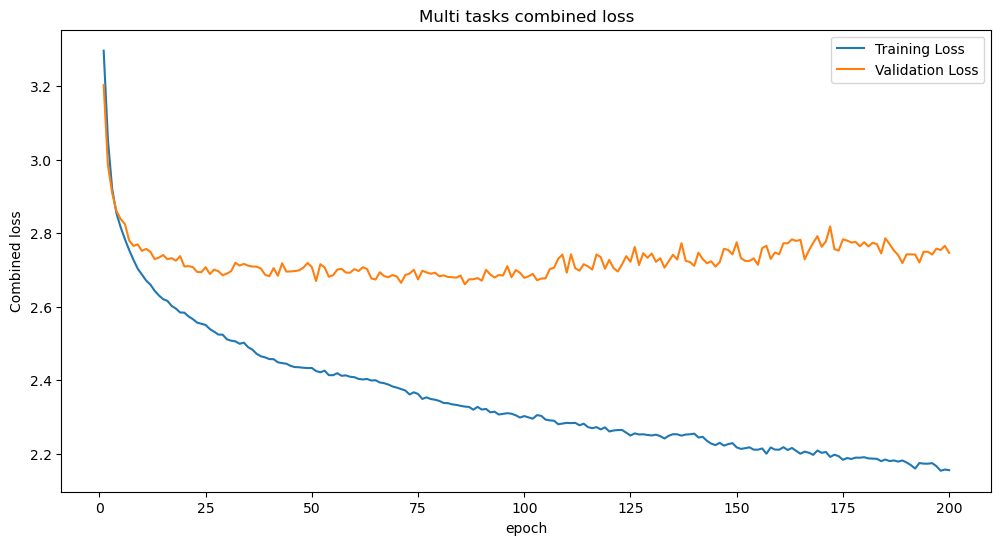

In [10]:
# train_batches = np.arange(1, train_losses_plot.shape[0]+1)
epoch_count = len(train_losses_plot)
train_epochs = np.arange(1, epoch_count+1)

# val_batches = np.arange(len(train_loader), train_losses_plot.shape[0]+1, len(train_loader))
# val_batches = len(val_loader)
val_epochs = np.arange(1, epoch_count+1)

plt.figure(figsize=(12, 6))

plt.plot(train_epochs, train_losses_plot, label='Training Loss')
plt.plot(val_epochs, val_losses_plot, label='Validation Loss')

plt.title('Multi tasks combined loss')
plt.xlabel('epoch')
plt.ylabel('Combined loss')

# Set the tick locations
# plt.xticks(arange(0, 21, 2))

# Display the plot
plt.legend(loc='best')
plt.show()

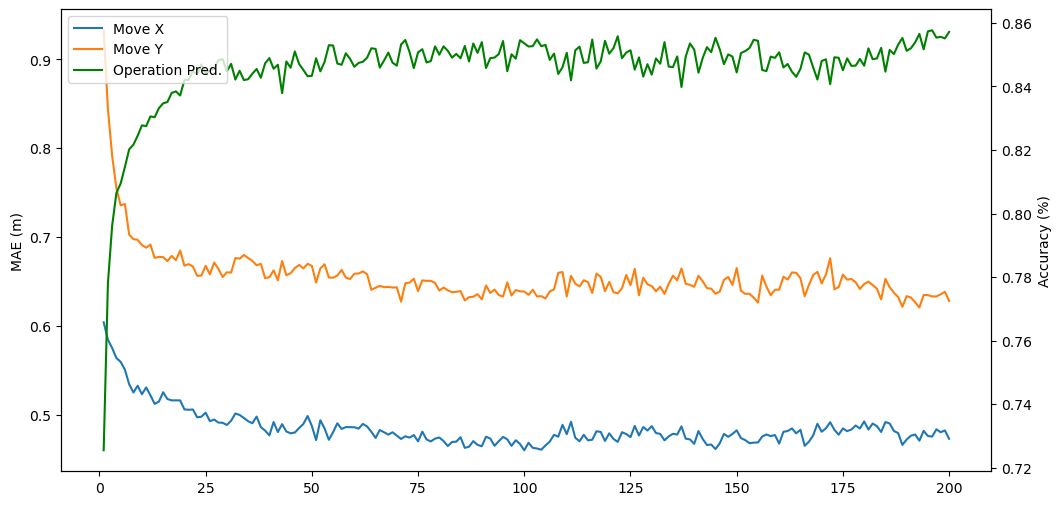

In [11]:
plt.figure(figsize=(12, 6))

xmae_line = plt.plot(val_epochs, val_xmae_plot, label='Move X')
ymae_line = plt.plot(val_epochs, val_ymae_plot, label='Move Y')
plt.ylabel("MAE (m)")

plt.twinx()

acc_line = plt.plot(val_epochs, val_acc_plot, color="green", label='Operation Pred.')
plt.ylabel("Accuracy (%)")

move_lines = xmae_line + ymae_line + acc_line
move_labels = [line.get_label() for line in move_lines]

plt.xlabel('epoch')
plt.legend(move_lines, move_labels, loc='upper left')
plt.show()

# Testing


Test set - Average Loss: 2.730355 - Op_F1: 0.857368 - Op_Acc: 0.858405 - X_MAE: 0.476690 - Y_MAE: 0.614164



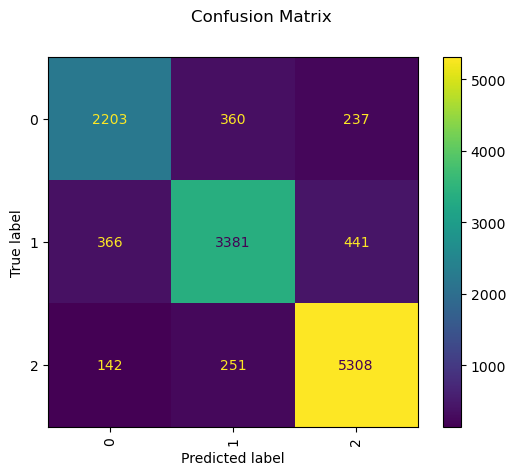

In [8]:
model = torch.load('simpl_2.pt', map_location=device)
test(model, test_loader, device)

In [9]:
model.loss_weights

Parameter containing:
tensor([0.4218, 0.4817, 0.5335], device='cuda:6', requires_grad=True)

In [10]:
from shapely.geometry import Polygon
import pandas as pd
import geopandas as gpd

def polygons_iou(polygon1, polygon2):
    intersect = polygon1.intersection(polygon2).area
    union = polygon1.union(polygon2).area
    return intersect / union

analysis_data = []

for i in range(len(test_set)):
    print('idx: {}'.format(i), end='\r')
    
    data = test_set[i]
    data.to(device)
    pred = model(data)
    
    xy = data.x.cpu()
    res_xy = data.y[:,1:].cpu()
    op = data.y[:,0].cpu()

    score_op = pred[0].detach().cpu()
    pred_op = score_op.argmax(dim=1)
    pred_res_x = pred[1].detach().cpu()
    pred_res_y = pred[2].detach().cpu()
    pred_res_xy = torch.stack((pred_res_x, pred_res_y)).transpose(0,1)

    target_xy_list = list()
    pred_xy_list = list()
    for i in range(len(op)):
        if op[i] != 2:
            target = xy[i] + res_xy[i]
            target_xy_list.append(target.tolist())

        if pred_op[i] != 2:
            pred = xy[i] + pred_res_xy[i]
            pred_xy_list.append(pred.tolist())
            
    target_xy = torch.tensor(target_xy_list)
    pred_xy = torch.tensor(pred_xy_list)
    
    if (pred_xy.shape[0] < 3):
        continue

    xy_pol = Polygon(xy)
    target_xy_pol = Polygon(target_xy)
    pred_xy_pol = Polygon(pred_xy)
    
    if not pred_xy_pol.is_valid:
        continue
    
    simpl_iou = polygons_iou(xy_pol, target_xy_pol)
    pred_iou = polygons_iou(target_xy_pol, pred_xy_pol)
    
    analysis_data.append({
        'poly_id': data.poly_id,
        'input': xy_pol,
        'target': target_xy_pol,
        'pred': pred_xy_pol,
        'simpl_iou': simpl_iou,
        'pred_iou': pred_iou
    })
    
analysis_df = pd.DataFrame(analysis_data, columns=['poly_id', 'input', 'target', 'pred', 'simpl_iou', 'pred_iou'])

/tmp/ipykernel_88/420608225.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [11]:
def get_simpl_level(x):
    if (x >= 0.9):
        return 'S1'
    elif (x >= 0.8):
        return 'S2'
    elif (x >= 0.7):
        return 'S3'
    elif (x >= 0.6):
        return 'S4'
    else:
        return 'S5'

analysis_df['simpl_level'] = analysis_df['simpl_iou'].apply(get_simpl_level)
analysis_df.head()

,poly_id,input,target,pred,simpl_iou,pred_iou,simpl_level
0,1222,POLYGON ((16.69792366027832 20.645071029663086...,POLYGON ((16.688617706298828 20.12199020385742...,POLYGON ((16.668874740600586 20.39299964904785...,0.856245,0.904099,S2
1,7472,"POLYGON ((3.5733556747436523 0, 3.072417974472...",POLYGON ((2.4400265216827393 -0.11577129364013...,POLYGON ((2.3277835845947266 -0.11071300506591...,0.945095,0.950719,S1
2,4337,"POLYGON ((5.655030250549316 19.68785285949707,...","POLYGON ((5.655030250549316 19.68785285949707,...","POLYGON ((5.655030250549316 19.68785285949707,...",1.000000,1.000000,S1
3,4651,POLYGON ((0.5120696425437927 5.045389175415039...,POLYGON ((0.0614627301692963 4.953308582305908...,POLYGON ((0.5281739234924316 5.044068336486816...,0.811556,0.849986,S2
4,2880,"POLYGON ((0 5.668445110321045, 5.5993704795837...",POLYGON ((-0.0994077995419502 5.44416618347168...,POLYGON ((-0.2288682907819748 5.40438604354858...,0.971049,0.992787,S1


In [12]:
from matplotlib import rcParams, rcParamsDefault

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Liberation Serif']
rcParams['font.size'] = 16

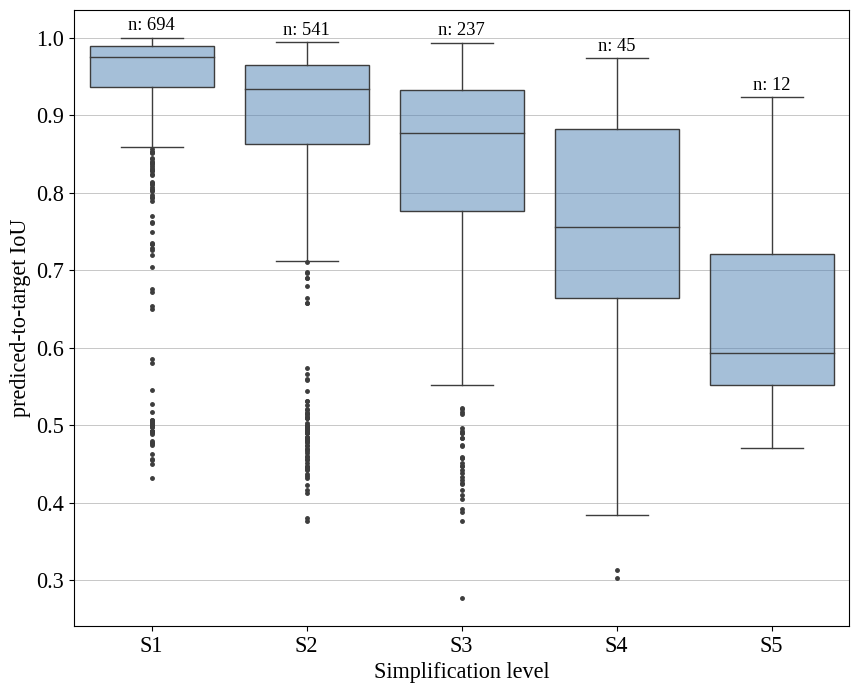

In [18]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 8))
box = sns.boxplot(data=analysis_df.sort_values(by=['simpl_level']), x="simpl_level", y="pred_iou",
                 flierprops={"marker": "."},
                 boxprops={"facecolor": (.3, .5, .7, .5)},
                 linewidth=1)
ax = box

# Calculate number of obs per group & median to position labels
medians = analysis_df.groupby(['simpl_level'])['pred_iou'].max().values
ndata = analysis_df['simpl_level'].value_counts().values
ndata = [str(x) for x in ndata.tolist()]
ndata = ["n: " + i for i in ndata]
 
# Add it to the plot
pos = range(len(ndata))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            medians[tick] + 0.01,
            ndata[tick],
            horizontalalignment='center',
            size='small',
            color='k')
            # weight='semibold')
ax.set_axisbelow(True)
ax.grid(axis='y', linewidth=.5)

plt.ylabel("prediced-to-target IoU")
plt.xlabel("Simplification level")
plt.show()
# plt.savefig("myplot.png")
fig.savefig("myplot.png")

In [13]:
from shapely.geometry import Polygon
import geopandas as gpd

def draw_building(df):
    for idx, row in df.iterrows():
        
        xy_pol = row.input
        target_xy_pol = row.target
        pred_xy_pol = row.pred
        
        xy_gs = gpd.GeoSeries(xy_pol)
        target_xy_gs = gpd.GeoSeries(target_xy_pol)
        pred_xy_gs = gpd.GeoSeries(pred_xy_pol)

        fig, ax = plt.subplots(figsize=(5, 5))
        xy_gs.plot(ax=ax, color='gray', alpha=0.5)
        target_xy_gs.plot(ax=ax, color='none', edgecolor='orange', linewidth=2)
        pred_xy_gs.plot(ax=ax, color='none', edgecolor='black', linestyle='dashed', linewidth=1)
        plt.show()

,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,S1,0.859059,0.936413,0.975551,0.989543,1.000000
1,S2,0.712189,0.863251,0.933570,0.965059,0.993987
2,S3,0.551231,0.776836,0.877206,0.932906,0.993275
3,S4,0.383531,0.664252,0.756056,0.881918,0.973260
4,S5,0.470262,0.552265,0.593446,0.720367,0.923127


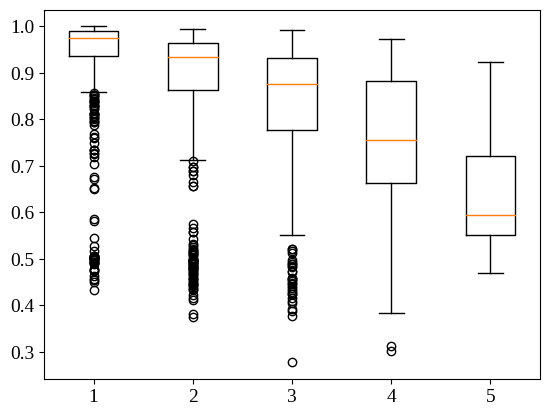

In [14]:
def get_box_plot_data(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

S1_iou  = analysis_df[analysis_df['simpl_level'] == 'S1']['pred_iou']
S2_iou  = analysis_df[analysis_df['simpl_level'] == 'S2']['pred_iou']
S3_iou  = analysis_df[analysis_df['simpl_level'] == 'S3']['pred_iou']
S4_iou  = analysis_df[analysis_df['simpl_level'] == 'S4']['pred_iou']
S5_iou  = analysis_df[analysis_df['simpl_level'] == 'S5']['pred_iou']

labels = ['S1', 'S2', 'S3', 'S4','S5']
bp = plt.boxplot([S1_iou, S2_iou, S3_iou, S4_iou, S5_iou])
bp_data = get_box_plot_data(labels, bp)
bp_data

In [150]:
S1  = analysis_df[analysis_df['simpl_level'] == 'S1']
S2  = analysis_df[analysis_df['simpl_level'] == 'S2']
S3  = analysis_df[analysis_df['simpl_level'] == 'S3']
S4  = analysis_df[analysis_df['simpl_level'] == 'S4']
S5  = analysis_df[analysis_df['simpl_level'] == 'S5']

s1_bp = bp_data[bp_data.label == 'S1']
s2_bp = bp_data[bp_data.label == 'S2']
s3_bp = bp_data[bp_data.label == 'S3']
s4_bp = bp_data[bp_data.label == 'S4']
s5_bp = bp_data[bp_data.label == 'S5']

# ------------------------

s1_1 = S1[S1['pred_iou'].between(s1_bp.upper_quartile[0], s1_bp.upper_whisker[0], inclusive='right')]
s1_2 = S1[S1['pred_iou'].between(s1_bp['median'][0], s1_bp.upper_quartile[0], inclusive='right')]
s1_3 = S1[S1['pred_iou'].between(s1_bp.lower_quartile[0], s1_bp['median'][0], inclusive='right')]
s1_4 = S1[S1['pred_iou'].between(s1_bp.lower_whisker[0], s1_bp.lower_quartile[0], inclusive='right')]
s1_5 = S1[S1['pred_iou'].lt(s1_bp.lower_whisker[0])]

s1_p1 = s1_1.sort_values(by=['pred_iou']).iloc[[70]]
s1_p2 = s1_2.sort_values(by=['pred_iou']).iloc[[int (s1_2.shape[0]/2)]]
s1_p3 = s1_3.sort_values(by=['pred_iou']).iloc[[int (s1_3.shape[0]/2)]]
s1_p4 = s1_4.sort_values(by=['pred_iou']).iloc[[int (s1_4.shape[0]/2)]]
s1_p5 = s1_5.sort_values(by=['pred_iou']).iloc[[int (s1_5.shape[0]/2)]]

# ------------------------

s2_1 = S2[S2['pred_iou'].between(s2_bp.upper_quartile.item(), s2_bp.upper_whisker.item(), inclusive='right')]
s2_2 = S2[S2['pred_iou'].between(s2_bp['median'].item(), s2_bp.upper_quartile.item(), inclusive='right')]
s2_3 = S2[S2['pred_iou'].between(s2_bp.lower_quartile.item(), s2_bp['median'].item(), inclusive='right')]
s2_4 = S2[S2['pred_iou'].between(s2_bp.lower_whisker.item(), s2_bp.lower_quartile.item(), inclusive='right')]
s2_5 = S2[S2['pred_iou'].lt(s2_bp.lower_whisker.item())]

s2_p1 = s2_1.sort_values(by=['pred_iou']).iloc[[int (s2_1.shape[0]/2)]]
s2_p2 = s2_2.sort_values(by=['pred_iou']).iloc[[int (s2_2.shape[0]/2)]]
s2_p3 = s2_3.sort_values(by=['pred_iou']).iloc[[int (s2_3.shape[0]/2)]]
s2_p4 = s2_4.sort_values(by=['pred_iou']).iloc[[int (s2_4.shape[0]/2)]]
s2_p5 = s2_5.sort_values(by=['pred_iou']).iloc[[int (s2_5.shape[0]/1.5)]]

# ------------------------

s3_1 = S3[S3['pred_iou'].between(s3_bp.upper_quartile.item(), s3_bp.upper_whisker.item(), inclusive='right')]
s3_2 = S3[S3['pred_iou'].between(s3_bp['median'].item(), s3_bp.upper_quartile.item(), inclusive='right')]
s3_3 = S3[S3['pred_iou'].between(s3_bp.lower_quartile.item(), s3_bp['median'].item(), inclusive='right')]
s3_4 = S3[S3['pred_iou'].between(s3_bp.lower_whisker.item(), s3_bp.lower_quartile.item(), inclusive='right')]
s3_5 = S3[S3['pred_iou'].lt(s3_bp.lower_whisker.item())]

s3_p1 = s3_1.sort_values(by=['pred_iou']).iloc[[int (s3_1.shape[0]/2)]]
s3_p2 = s3_2.sort_values(by=['pred_iou']).iloc[[int (s3_2.shape[0]/2)]]
s3_p3 = s3_3.sort_values(by=['pred_iou']).iloc[[int (s3_3.shape[0]/2)]]
s3_p4 = s3_4.sort_values(by=['pred_iou']).iloc[[int (s3_4.shape[0]/2)]]
s3_p5 = s3_5.sort_values(by=['pred_iou']).iloc[[int (s3_5.shape[0]/2)]]

# ------------------------

s4_1 = S4[S4['pred_iou'].between(s4_bp.upper_quartile.item(), s4_bp.upper_whisker.item(), inclusive='right')]
s4_2 = S4[S4['pred_iou'].between(s4_bp['median'].item(), s4_bp.upper_quartile.item(), inclusive='right')]
s4_3 = S4[S4['pred_iou'].between(s4_bp.lower_quartile.item(), s4_bp['median'].item(), inclusive='right')]
s4_4 = S4[S4['pred_iou'].between(s4_bp.lower_whisker.item(), s4_bp.lower_quartile.item(), inclusive='right')]
s4_5 = S4[S4['pred_iou'].lt(s4_bp.lower_whisker.item())]

s4_p1 = s4_1.sort_values(by=['pred_iou']).iloc[[int (s4_1.shape[0]/2)]]
s4_p2 = s4_2.sort_values(by=['pred_iou']).iloc[[int (s4_2.shape[0]/2)]]
s4_p3 = s4_3.sort_values(by=['pred_iou']).iloc[[int (s4_3.shape[0]/2)]]
s4_p4 = s4_4.sort_values(by=['pred_iou']).iloc[[int (s4_4.shape[0]/2)]]
s4_p5 = s4_5.sort_values(by=['pred_iou']).iloc[[int (s4_5.shape[0]/2)]]

# ------------------------

s5_1 = S5[S5['pred_iou'].between(s5_bp.upper_quartile.item(), s5_bp.upper_whisker.item())]
s5_2 = S5[S5['pred_iou'].between(s5_bp['median'].item(), s5_bp.upper_quartile.item(), inclusive='right')]
s5_3 = S5[S5['pred_iou'].between(s5_bp.lower_quartile.item(), s5_bp['median'].item(), inclusive='right')]
s5_4 = S5[S5['pred_iou'].between(s5_bp.lower_whisker.item(), s5_bp.lower_quartile.item())]

s5_p1 = s5_1.sort_values(by=['pred_iou']).iloc[[s5_1.shape[0]-1]]
s5_p2 = s5_2.sort_values(by=['pred_iou']).iloc[[s5_2.shape[0]-1]]
s5_p3 = s5_3.sort_values(by=['pred_iou']).iloc[[int (s5_3.shape[0]/1.5)]]
s5_p4 = s5_4.sort_values(by=['pred_iou']).iloc[[int (s5_4.shape[0]/2)]]

In [220]:
s5_p4

,poly_id,input,target,pred,simpl_iou,pred_iou,simpl_level
1075,5910,POLYGON ((1.6475284099578857 27.40920066833496...,POLYGON ((0.5722808837890625 24.81708145141601...,POLYGON ((1.6475284099578857 27.40920066833496...,0.552896,0.529406,S5


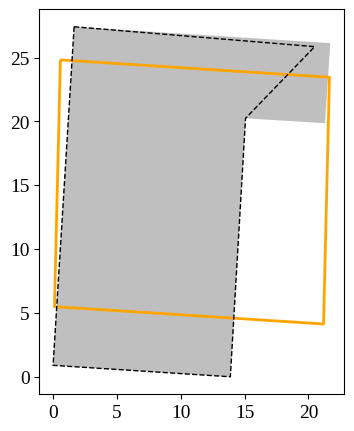

In [221]:
# draw_building(S5[S5.pred_iou == S5.pred_iou.max()])
draw_building(s5_p4)